## Setup

In [1]:
import os
import optuna
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.metrics import f1_score
import joblib

from src.py_src import util
from src.py_src.models import Specialist910Model

C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
slided_df_path = os.path.join(os.getenv("SLIDED_DFS_CSV_PATH"), "data_slided_V4.parquet")
target_class = 'target_class_in_12h'
target_flux = 'target_flux_in_12h'
target_columns = [target_class, target_flux]

buffer_limits = (8.0e-6, 2.0e-5)

df_model_input = util.create_df_model_input_opt(slided_df_path, target_columns, "xl_")

Carregando 56 colunas do arquivo Parquet...


## Preparing Data

In [4]:
specialist_910_pool = df_model_input[df_model_input[target_class] > 2].copy()

train_pct = 0.7
val_pct = (1-train_pct)/2

data = util.prepare_data(
    df_model_input=specialist_910_pool,
    target_class_col=target_class,
    lambda_function=lambda lb: 1 if lb >= 4 else 0,
    train_pct=train_pct,
    val_pct=val_pct,
    target_flux_col=target_flux
)

## Discovery Model

In [5]:
discovery_model = Specialist910Model(
    params={
        'n_estimators': 300,
        'learning_rate': 0.05,
        'max_depth': 5,
        'n_jobs': -1,
        'random_state': 42
    },
    buffer_limits=buffer_limits
)

In [6]:
selected_features = discovery_model.discover_top_features(
    x=data['x']['train'],
    y=data['y']['train'],
    flux_values=data['flux']['train'],
    cumulative_threshold=0.95
)

--- Quick Scan (Discovery Mode) ---
Quick Scan concluído. 41 features selecionadas (de 54).


## Hyperparameter Tuning (Optuna)

In [7]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 1000,
        'random_state': 1502,
        'n_jobs': -1,
        'early_stopping_rounds': 50,
        'device': 'cuda',

        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 1.0, 5.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = Specialist910Model(params=params, buffer_limits=buffer_limits, features_to_keep=selected_features)

    model.fit(
        x=data['x']['train'],
        y=data['y']['train'],
        flux_values=data['flux']['train'],
        eval_set=[(data['x']['val'], data['y']['val'])],
        verbose=False
    )

    y_pred_val = model.predict_proba(data['x']['val'])[:, 1]

    y_pred_class = (y_pred_val >= 0.5).astype(int)

    return f1_score(data['y']['val'], y_pred_class, average='macro')

In [9]:
study = optuna.create_study(direction='maximize')
print("\nIniciando tuning...")
study.optimize(objective, n_trials=10)

print(f"\nBest Score: {study.best_value:.4f}")
best_params = study.best_params

best_params.update({
    'n_estimators': 1000, 'objective': 'binary:logistic',
    'eval_metric': 'logloss', 'random_state': 1502,
    'n_jobs': -1, 'early_stopping_rounds': 50
})

[I 2025-12-15 21:00:08,864] A new study created in memory with name: no-name-f7946378-946d-4b5a-beb8-eb5cbcba8d07



Iniciando tuning...


[I 2025-12-15 21:00:12,526] Trial 0 finished with value: 0.6276515709829837 and parameters: {'scale_pos_weight': 1.0120847335510637, 'max_depth': 3, 'learning_rate': 0.014916316957868632, 'subsample': 0.8188075583388409, 'colsample_bytree': 0.6532914181339028, 'gamma': 4.924452443507131, 'min_child_weight': 7}. Best is trial 0 with value: 0.6276515709829837.
[I 2025-12-15 21:00:19,592] Trial 1 finished with value: 0.6554929782566533 and parameters: {'scale_pos_weight': 3.367199429716773, 'max_depth': 8, 'learning_rate': 0.04945631796471461, 'subsample': 0.6142859251513667, 'colsample_bytree': 0.7802346350212455, 'gamma': 2.8868504712777066, 'min_child_weight': 3}. Best is trial 1 with value: 0.6554929782566533.
[I 2025-12-15 21:00:32,386] Trial 2 finished with value: 0.6720949192088288 and parameters: {'scale_pos_weight': 2.862404949046596, 'max_depth': 7, 'learning_rate': 0.011726912287791581, 'subsample': 0.8791076836761351, 'colsample_bytree': 0.79783862920129, 'gamma': 2.9877535169


Best Score: 0.6872


In [10]:
final_model = Specialist910Model(params=study.best_params, buffer_limits=buffer_limits, features_to_keep=selected_features)
final_model.fit(
    x=data['x']['train'], y=data['y']['train'],
    flux_values=data['flux']['train']
)

,params,"{'colsample_bytree': 0.7716853497366357, 'gamma': 0.7805770822304292, 'learning_rate': 0.18907288683192272, 'max_depth': 3, ...}"
,buffer_limits,None
,buffer_weight,0.2
,threshold,0.5
,features_to_keep,"['xl_integ_24h', 'xl_mean_12h', ...]"


## Threshold Tuning

In [11]:
fig = final_model.get_threshold_graph(data['x']['test'], data['y']['test'])
plt.show()

In [12]:
final_model.optimize_threshold(data['x']['test'], data['y']['test'])

Threshold de Equilíbrio (P=R): 0.5741


np.float32(0.5740978)

## Results

In [13]:
print(final_model.get_classification_report(
    data['x']['test'], data['y']['test'], target_names=['C', 'MX']
))

              precision    recall  f1-score   support

           C       0.68      0.68      0.68     57004
          MX       0.60      0.60      0.60     45436

    accuracy                           0.65    102440
   macro avg       0.64      0.64      0.64    102440
weighted avg       0.65      0.65      0.65    102440



In [14]:
fig, summary = final_model.analyze_flux_errors(
    data['x']['test'], data['y']['test'],
    flux_values=data['flux']['test'],
    buffer_limits=buffer_limits
)
display(summary)
plt.show()

Outcome,TN (Correct Rejection),FP (False Alarm),FP Rate (%),TP (Hit),FN (Miss),FN Rate (%)
Zone,,,,,,
1. Safe Zone (Low Flux),35156,14001,28.5,0,0,NaN
2. Buffer Zone,3797,4050,51.6,11394,9666,45.9
3. Safe Zone (High Flux),0,0,NaN,15991,8385,34.4


In [15]:
error_report = final_model.analyze_error_distribution(
    x=data['x']['test'],
    y_true=data['y']['test'],
    flux_values=data['flux']['test']
)
display(error_report)

,FN (Miss),FP (False Alarm),FN (Miss) Avg Flux,FP (False Alarm) Avg Flux
SolarClass,,,,
C (1.0 - 9.9),3,18051,9.00e-06,6.03e-06
M (1.0 - 9.9),16633,0,2.56e-05,-
X (> M10),1415,0,2.15e-04,-


## Features Importance

In [16]:
features_importance = final_model.get_feature_importance()
features_importance

,feature,importance,cumulative_importance
1,xl_mean_12h,0.339639,0.339639
0,xl_integ_24h,0.140286,0.479925
9,xl_max_6h,0.095410,0.575335
5,xl_integ_12h,0.079088,0.654423
4,xl_mean_6h,0.065014,0.719437
8,xl_std_12h,0.025897,0.745335
6,xl_std_1h,0.019315,0.764650
2,xl_mean_24h,0.019126,0.783776
3,xl_max_1h,0.014863,0.798639
37,xl_mean_1h,0.013197,0.811835


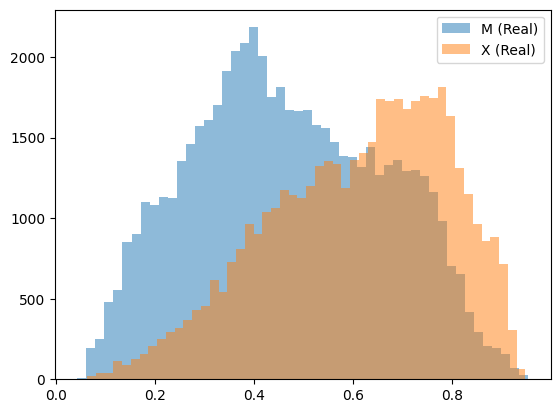

In [17]:
y_proba = final_model.predict_proba(data['x']['test'])[:, 1]
plt.hist(y_proba[data['y']['test']==0], bins=50, alpha=0.5, label='M (Real)')
plt.hist(y_proba[data['y']['test']==1], bins=50, alpha=0.5, label='X (Real)')
plt.legend()
plt.show()

## Export

In [18]:
specialist_910_dir = os.getenv('SPECIALIST_910_MODELS_PATH')
save_path = os.path.join(specialist_910_dir, '12h/specialist_910_12h_v1.joblib')
final_model.save(save_path)

Modelo salvo em: C:\Users\Eduardo\BES\IC\Solar_Flares\src\notebooks\models\specialist_910\12h/specialist_910_12h_v1.joblib
